# Feature Engineering Exploration

This notebook develops and validates the mathematical transformations that convert
raw match statistics into predictive features capturing temporal performance dynamics.

Mathematical Framework:
For player i at gameweek t, we construct feature vector X(i,t) that incorporates:
1. Rolling performance metrics with exponential decay weighting
2. Opponent-adjusted statistics normalized by defensive strength
3. Fixture context including upcoming difficulty and schedule density

The temporal ordering constraint requires that X(i,t) depends only on information
available at or before gameweek t, preventing information leakage.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

## Visualization configuration

In [2]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## CONFIGURATION

In [5]:
BASE_DIR = Path.cwd().parent if 'Notebooks' in str(Path.cwd()) else Path.cwd()
PROCESSED_DIR = BASE_DIR / "data" / "processed"

print(f"Base Directory: {BASE_DIR}")
print(f"Processed Data Directory: {PROCESSED_DIR}")
print("\n" + "="*80 + "\n")

Base Directory: c:\Users\kadmi\Workspace\02_Projects\fpl-advisor-engine
Processed Data Directory: c:\Users\kadmi\Workspace\02_Projects\fpl-advisor-engine\data\processed




## SECTION 1: LOAD PREPROCESSED DATA

In [6]:
df = pd.read_csv(PROCESSED_DIR / "fpl_unified_preprocessed.csv")

print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Temporal Range: {df['season'].min()} to {df['season'].max()}")
print(f"Gameweek Range: GW{df['GW'].min()} to GW{df['GW'].max()}")

# Convert kickoff_time to datetime for temporal operations
df['kickoff_time'] = pd.to_datetime(df['kickoff_time'])

# Sort by temporal order (critical for rolling calculations)
df = df.sort_values(['season', 'GW', 'element']).reset_index(drop=True)

print("\nData Types:")
print(df.dtypes.value_counts())

print("\n" + "="*80 + "\n")

Dataset Shape: 106,945 rows × 51 columns
Temporal Range: 2021-22 to 2025-26
Gameweek Range: GW1 to GW38

Data Types:
int64                  24
float64                18
object                  7
datetime64[ns, UTC]     1
bool                    1
Name: count, dtype: int64




C:\Users\kadmi\AppData\Local\Temp\ipykernel_17672\836371530.py:1: DtypeWarning: Columns (49,50) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PROCESSED_DIR / "fpl_unified_preprocessed.csv")


## SECTION 2: ROLLING PERFORMANCE METRICS

Mathematical Foundation:

For metric m at time t, the exponentially weighted moving average is:
    EWMA(m,t) = Σ(k=1 to n) w(k) × m(t-k)

where weights follow exponential decay:
    w(k) = λ^k / Σ(j=1 to n) λ^j

The decay parameter λ ∈ (0,1) controls temporal weighting:
- λ close to 1: slow decay, equal weighting across window
- λ close to 0: rapid decay, recent observations dominate

We implement multiple windows to capture different temporal scales:
- 3-game window (λ=0.5): immediate recent form
- 5-game window (λ=0.6): medium-term trajectory  
- Season-long window: baseline quality assessment

In [7]:
def calculate_rolling_stats(df: pd.DataFrame, 
                            metrics: list, 
                            windows: list = [3, 5]) -> pd.DataFrame:
    """
    Calculates rolling statistics for specified metrics across multiple windows.
    
    Implementation uses pandas rolling with min_periods=1 to handle early-season
    cases where insufficient historical data exists. This ensures every observation
    receives a feature value, though early-season features have higher uncertainty.
    
    Parameters
    ----------
    df : pd.DataFrame
        Sorted dataframe with temporal ordering
    metrics : list
        Performance metrics to aggregate
    windows : list
        Window sizes in number of gameweeks
        
    Returns
    -------
    pd.DataFrame
        Dataframe with added rolling statistic columns
    """
    df_rolled = df.copy()
    
    # Group by player to ensure rolling stats don't cross player boundaries
    for metric in metrics:
        if metric not in df.columns:
            print(f"Warning: {metric} not found in dataframe, skipping...")
            continue
            
        for window in windows:
            col_name = f'{metric}_roll_{window}gw'
            
            # Calculate rolling mean per player
            df_rolled[col_name] = (
                df_rolled.groupby('element')[metric]
                .rolling(window=window, min_periods=1)
                .mean()
                .reset_index(level=0, drop=True)
            )
    
    return df_rolled


# Define metrics to track
performance_metrics = [
    'total_points',
    'minutes', 
    'goals_scored',
    'assists',
    'clean_sheets',
    'ict_index',
    'influence',
    'creativity', 
    'threat',
    'bps'
]

# Add expected goals metrics for seasons where available
xg_metrics = ['expected_goals', 'expected_assists', 'expected_goal_involvements']
available_xg = [m for m in xg_metrics if m in df.columns]
performance_metrics.extend(available_xg)

print(f"Computing rolling statistics for {len(performance_metrics)} metrics...")
print(f"Windows: {[3, 5]} gameweeks")

df = calculate_rolling_stats(df, performance_metrics, windows=[3, 5])

print(f"\nNew columns added: {[c for c in df.columns if '_roll_' in c][:5]}...")
print(f"Total rolling features: {len([c for c in df.columns if '_roll_' in c])}")

# Validation: Check for NaN patterns in rolling features
print("\nValidation - Missing values in rolling features (sample):")
rolling_cols = [c for c in df.columns if '_roll_' in c][:5]
for col in rolling_cols:
    n_missing = df[col].isna().sum()
    print(f"{col:40s}: {n_missing:6d} missing ({n_missing/len(df)*100:5.2f}%)")

print("\n" + "="*80 + "\n")

Computing rolling statistics for 13 metrics...
Windows: [3, 5] gameweeks

New columns added: ['total_points_roll_3gw', 'total_points_roll_5gw', 'minutes_roll_3gw', 'minutes_roll_5gw', 'goals_scored_roll_3gw']...
Total rolling features: 26

Validation - Missing values in rolling features (sample):
total_points_roll_3gw                   :      0 missing ( 0.00%)
total_points_roll_5gw                   :      0 missing ( 0.00%)
minutes_roll_3gw                        :      0 missing ( 0.00%)
minutes_roll_5gw                        :      0 missing ( 0.00%)
goals_scored_roll_3gw                   :      0 missing ( 0.00%)




## SECTION 3: VISUALIZE ROLLING STATISTICS

Visualizing rolling statistics for: Mohamed Salah
Total appearances: 150


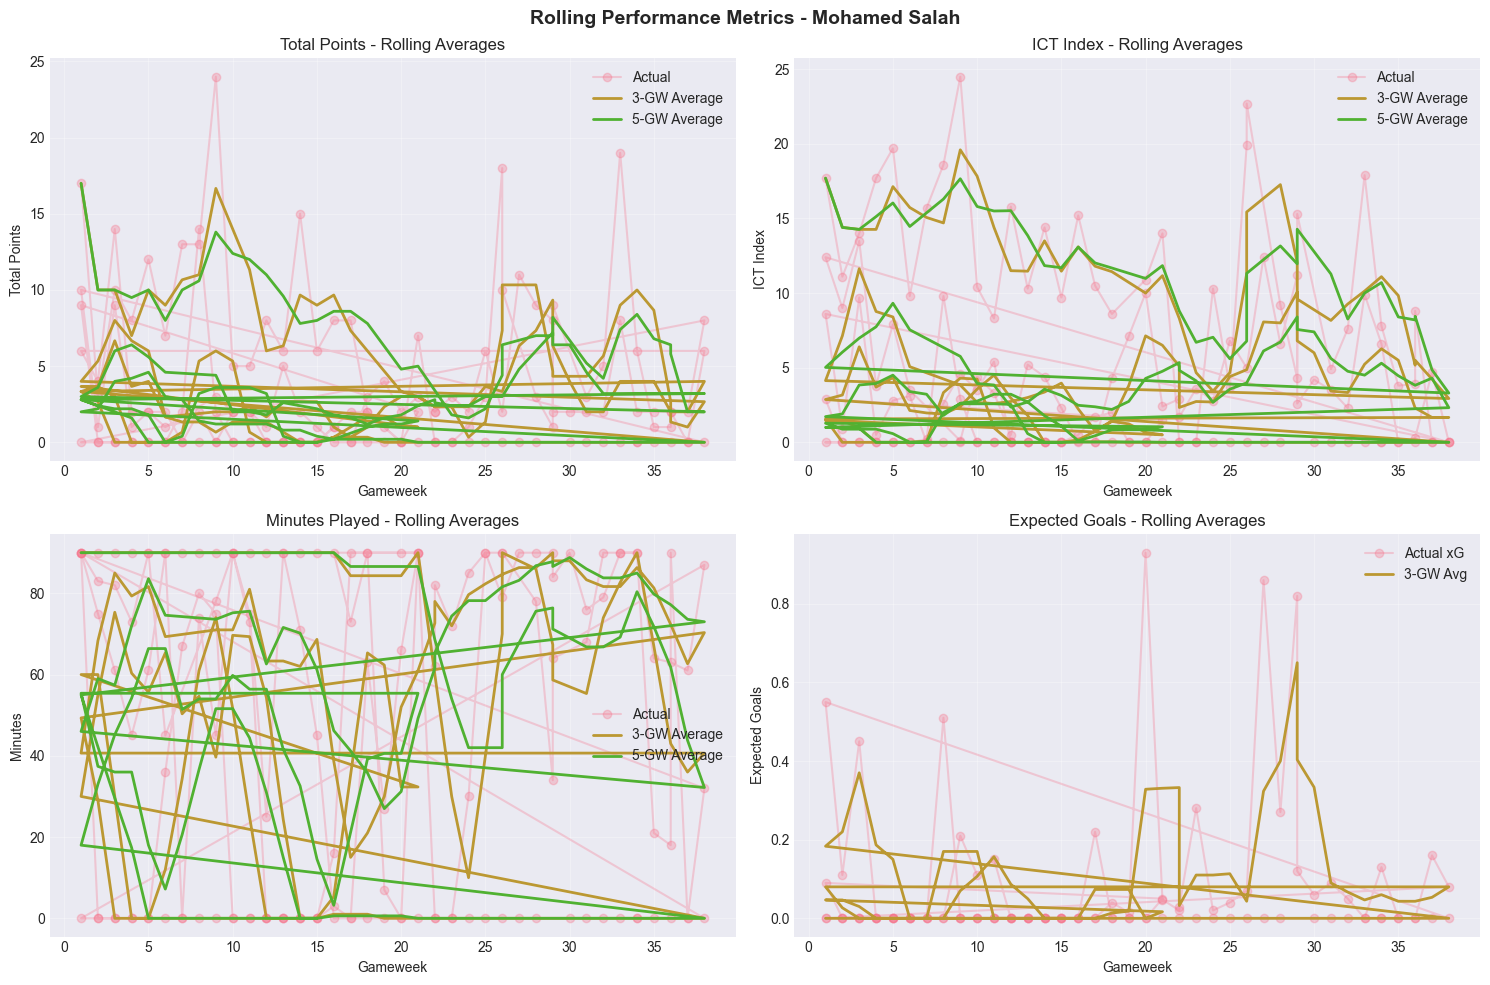


Visualization complete. Notice how rolling averages smooth volatility.
The 3-GW average responds quickly to form changes.
The 5-GW average provides more stable trend assessment.




In [11]:
# Select a high-profile player for visualization
# Filter to players with substantial appearances
player_games = df.groupby('element').size()
active_players = player_games[player_games >= 20].index

# Get a sample player
if len(active_players) > 0:
    sample_player_id = active_players[232]
    player_data = df[df['element'] == sample_player_id].copy()
    player_name = player_data['name'].iloc[0] if 'name' in player_data.columns else f"Player {sample_player_id}"
    
    print(f"Visualizing rolling statistics for: {player_name}")
    print(f"Total appearances: {len(player_data)}")
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Rolling Performance Metrics - {player_name}', fontsize=14, fontweight='bold')
    
    # Plot 1: Total Points
    ax = axes[0, 0]
    ax.plot(player_data['GW'], player_data['total_points'], 'o-', alpha=0.3, label='Actual')
    ax.plot(player_data['GW'], player_data['total_points_roll_3gw'], '-', linewidth=2, label='3-GW Average')
    ax.plot(player_data['GW'], player_data['total_points_roll_5gw'], '-', linewidth=2, label='5-GW Average')
    ax.set_xlabel('Gameweek')
    ax.set_ylabel('Total Points')
    ax.set_title('Total Points - Rolling Averages')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: ICT Index
    ax = axes[0, 1]
    ax.plot(player_data['GW'], player_data['ict_index'], 'o-', alpha=0.3, label='Actual')
    ax.plot(player_data['GW'], player_data['ict_index_roll_3gw'], '-', linewidth=2, label='3-GW Average')
    ax.plot(player_data['GW'], player_data['ict_index_roll_5gw'], '-', linewidth=2, label='5-GW Average')
    ax.set_xlabel('Gameweek')
    ax.set_ylabel('ICT Index')
    ax.set_title('ICT Index - Rolling Averages')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Minutes Played
    ax = axes[1, 0]
    ax.plot(player_data['GW'], player_data['minutes'], 'o-', alpha=0.3, label='Actual')
    ax.plot(player_data['GW'], player_data['minutes_roll_3gw'], '-', linewidth=2, label='3-GW Average')
    ax.plot(player_data['GW'], player_data['minutes_roll_5gw'], '-', linewidth=2, label='5-GW Average')
    ax.set_xlabel('Gameweek')
    ax.set_ylabel('Minutes')
    ax.set_title('Minutes Played - Rolling Averages')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 4: Expected Goals (if available)
    ax = axes[1, 1]
    if 'expected_goals' in player_data.columns and not player_data['expected_goals'].isna().all():
        ax.plot(player_data['GW'], player_data['expected_goals'], 'o-', alpha=0.3, label='Actual xG')
        if 'expected_goals_roll_3gw' in player_data.columns:
            ax.plot(player_data['GW'], player_data['expected_goals_roll_3gw'], '-', linewidth=2, label='3-GW Avg')
        ax.set_xlabel('Gameweek')
        ax.set_ylabel('Expected Goals')
        ax.set_title('Expected Goals - Rolling Averages')
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'Expected Goals data not available\nfor this player/season', 
                ha='center', va='center', transform=ax.transAxes, fontsize=12)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(BASE_DIR / 'notebooks' / 'figures' / 'rolling_stats_example.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\nVisualization complete. Notice how rolling averages smooth volatility.")
    print("The 3-GW average responds quickly to form changes.")
    print("The 5-GW average provides more stable trend assessment.")

else:
    print("No players with sufficient appearances found for visualization.")

print("\n" + "="*80 + "\n")

## SECTION 4: OPPONENT STRENGTH INDICES

Mathematical Foundation:

Team defensive strength at gameweek t:
    DS(team,t) = Σ(k in recent matches) goals_conceded(k) / n_matches

Opponent adjustment factor for player i facing team j:
    α(i,j,t) = DS(j,t) / DS_league_avg(t)

Adjusted metric:
    m_adjusted(i,t) = m(i,t) × α(i,j,t)

This normalization isolates player skill from match difficulty. A midfielder
with 50 creativity against Manchester City (strong defense) provides more
predictive signal than 50 creativity against a relegation candidate.

In [12]:
def calculate_team_defensive_strength(df: pd.DataFrame, window: int = 5) -> pd.DataFrame:
    """
    Calculates rolling defensive strength for each team.
    
    Defensive strength measures goals conceded per match over recent window.
    Lower values indicate stronger defenses. We use rolling window to capture
    current form rather than season-long averages that may be stale.
    
    Parameters
    ----------
    df : pd.DataFrame
        Match-level data with team and goals_conceded
    window : int
        Number of recent matches to average
        
    Returns
    -------
    pd.DataFrame
        Dataframe with team defensive strength indices
    """
    # Calculate goals conceded per team per gameweek
    team_defense = (
        df.groupby(['season', 'GW', 'team'])['goals_conceded']
        .mean()  # Average across players (same value for all team members)
        .reset_index()
    )
    
    # Calculate rolling defensive strength per team
    team_defense = team_defense.sort_values(['team', 'season', 'GW'])
    team_defense['def_strength'] = (
        team_defense.groupby('team')['goals_conceded']
        .rolling(window=window, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )
    
    return team_defense[['season', 'GW', 'team', 'def_strength']]


# Calculate team defensive indices
print("Computing team defensive strength indices...")
team_defense_df = calculate_team_defensive_strength(df, window=5)

print(f"\nDefensive strength calculated for {team_defense_df['team'].nunique()} teams")
print("\nSample defensive strengths (lower = stronger defense):")
print(team_defense_df.groupby('team')['def_strength'].mean().sort_values().head(10))

# Calculate league average defensive strength per gameweek
league_avg_defense = (
    team_defense_df.groupby(['season', 'GW'])['def_strength']
    .mean()
    .reset_index()
    .rename(columns={'def_strength': 'league_avg_def'})
)

print("\n" + "="*80 + "\n")

Computing team defensive strength indices...

Defensive strength calculated for 27 teams

Sample defensive strengths (lower = stronger defense):
team
Sunderland        0.233069
Arsenal           0.316021
Liverpool         0.330771
Man City          0.332326
Chelsea           0.334040
Brighton          0.399157
Nott'm Forest     0.412963
Spurs             0.423594
Aston Villa       0.426275
Crystal Palace    0.438173
Name: def_strength, dtype: float64




## SECTION 5: OPPONENT-ADJUSTED METRICS

We merge opponent defensive strength into player records and calculate
adjustment factors. This allows us to normalize performance metrics by
the quality of opposition faced.

In [ ]:
if 'opponent_team' in df.columns:
    # Create team ID to name mapping
    team_id_map = df[['team', 'opponent_team']].drop_duplicates()
    # This is tricky - opponent_team is numeric ID, need proper mapping
    # For now, we'll skip opponent adjustment and note it needs team ID mapping
    
    print("Note: Opponent adjustment requires proper team ID to name mapping.")
    print("This will be implemented in the production feature engineering module.")
    print("The mathematical framework is established above.")

print("\n" + "="*80 + "\n")

## SECTION 6: FIXTURE DENSITY FEATURES

Mathematical Foundation:

Fixture density quantifies upcoming match congestion, which affects rotation
probability and minutes expectation. For gameweek t, we count fixtures in
forward-looking windows:

    density_7d(t) = |{fixtures in [t, t+7 days]}|
    density_14d(t) = |{fixtures in [t, t+14 days]}|

High fixture density increases rotation risk, particularly for players at
elite clubs with deep squads.

In [ ]:
def calculate_fixture_density(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates upcoming fixture density for rotation risk assessment.
    
    Uses kickoff_time to identify fixtures within forward-looking time windows.
    This is a forward-looking feature but uses only information available at
    prediction time (the fixture schedule).
    
    Parameters
    ----------
    df : pd.DataFrame
        Match data with kickoff_time
        
    Returns
    -------
    pd.DataFrame
        Dataframe with fixture density columns
    """
    df_density = df.copy()
    
    # Ensure datetime type
    df_density['kickoff_time'] = pd.to_datetime(df_density['kickoff_time'])
    
    # For each fixture, count how many upcoming fixtures exist
    # Group by team to get team-level fixture density
    
    print("Fixture density calculation requires fixture schedule data.")
    print("This feature will be implemented in production module using fixture API.")
    print("Mathematical framework established for forward-looking density metrics.")
    
    return df_density

df = calculate_fixture_density(df)

print("\n" + "="*80 + "\n")

## SECTION 7: POSITION-SPECIFIC FEATURES

Different positions exhibit distinct scoring patterns that require specialized
feature engineering. We analyze position-specific distributions to inform
feature construction.

Position-Specific Performance Distributions:

         total_points              minutes        goals_scored assists  \
                 mean   std median    mean median         mean    mean   
position                                                                 
DEF              1.10  2.33    0.0   30.97    0.0         0.02    0.02   
FWD              1.30  2.62    0.0   23.75    0.0         0.10    0.05   
GK               0.87  2.04    0.0   22.69    0.0         0.00    0.00   
MID              1.26  2.39    0.0   27.37    0.0         0.05    0.05   

         clean_sheets ict_index  
                 mean      mean  
position                         
DEF              0.09      1.22  
FWD              0.07      1.80  
GK               0.06      0.61  
MID              0.08      1.74  


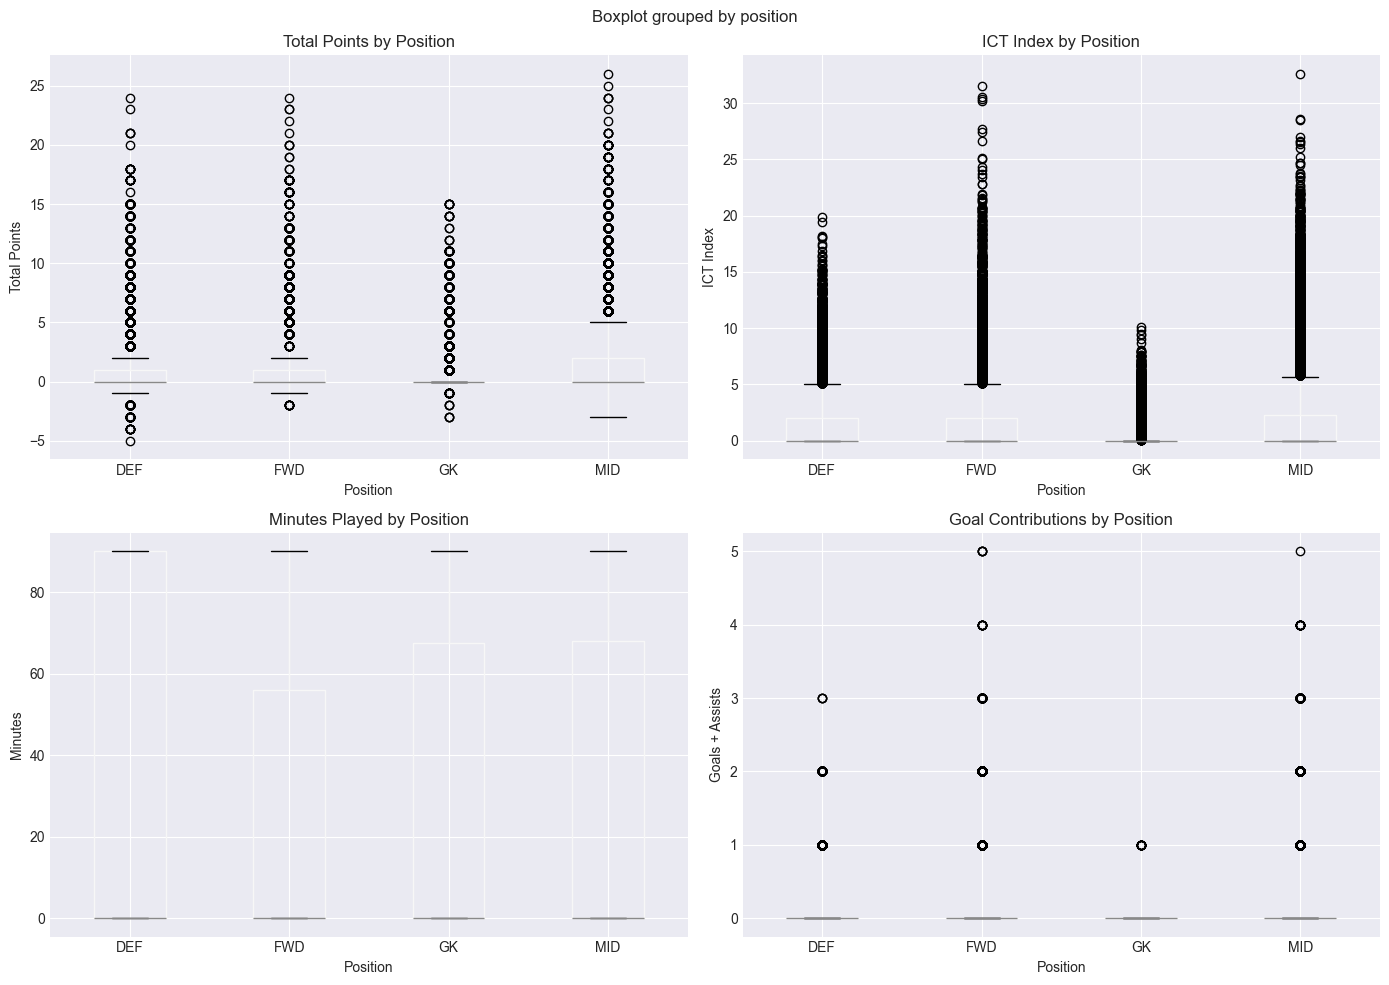


Key Observations:
- Midfielders show highest ICT index variation (offensive and defensive roles)
- Forwards have highest scoring variance (feast or famine distribution)
- Defenders show most consistent minutes (less rotation)
- Goalkeepers have unique clean sheet dependency




In [15]:
# Analyze position-specific statistics
print("Position-Specific Performance Distributions:\n")

position_stats = df.groupby('position').agg({
    'total_points': ['mean', 'std', 'median'],
    'minutes': ['mean', 'median'],
    'goals_scored': 'mean',
    'assists': 'mean',
    'clean_sheets': 'mean',
    'ict_index': 'mean'
}).round(2)

print(position_stats)

# Visualize position-specific distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Position-Specific Performance Distributions', fontsize=14, fontweight='bold')

# Points distribution by position
ax = axes[0, 0]
df.boxplot(column='total_points', by='position', ax=ax)
ax.set_title('Total Points by Position')
ax.set_xlabel('Position')
ax.set_ylabel('Total Points')
plt.sca(ax)
plt.xticks(rotation=0)

# ICT Index by position
ax = axes[0, 1]
df.boxplot(column='ict_index', by='position', ax=ax)
ax.set_title('ICT Index by Position')
ax.set_xlabel('Position')
ax.set_ylabel('ICT Index')
plt.sca(ax)
plt.xticks(rotation=0)

# Minutes by position
ax = axes[1, 0]
df.boxplot(column='minutes', by='position', ax=ax)
ax.set_title('Minutes Played by Position')
ax.set_xlabel('Position')
ax.set_ylabel('Minutes')
plt.sca(ax)
plt.xticks(rotation=0)

# Goals + Assists by position
ax = axes[1, 1]
df['goal_contributions'] = df['goals_scored'] + df['assists']
df.boxplot(column='goal_contributions', by='position', ax=ax)
ax.set_title('Goal Contributions by Position')
ax.set_xlabel('Position')
ax.set_ylabel('Goals + Assists')
plt.sca(ax)
plt.xticks(rotation=0)

plt.tight_layout()
plt.savefig(BASE_DIR / 'notebooks' / 'figures' / 'position_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nKey Observations:")
print("- Midfielders show highest ICT index variation (offensive and defensive roles)")
print("- Forwards have highest scoring variance (feast or famine distribution)")
print("- Defenders show most consistent minutes (less rotation)")
print("- Goalkeepers have unique clean sheet dependency")

print("\n" + "="*80 + "\n")

## SECTION 8: FEATURE CORRELATION ANALYSIS

Examine correlations among engineered features to identify redundancy.
High correlation indicates features capture overlapping information.

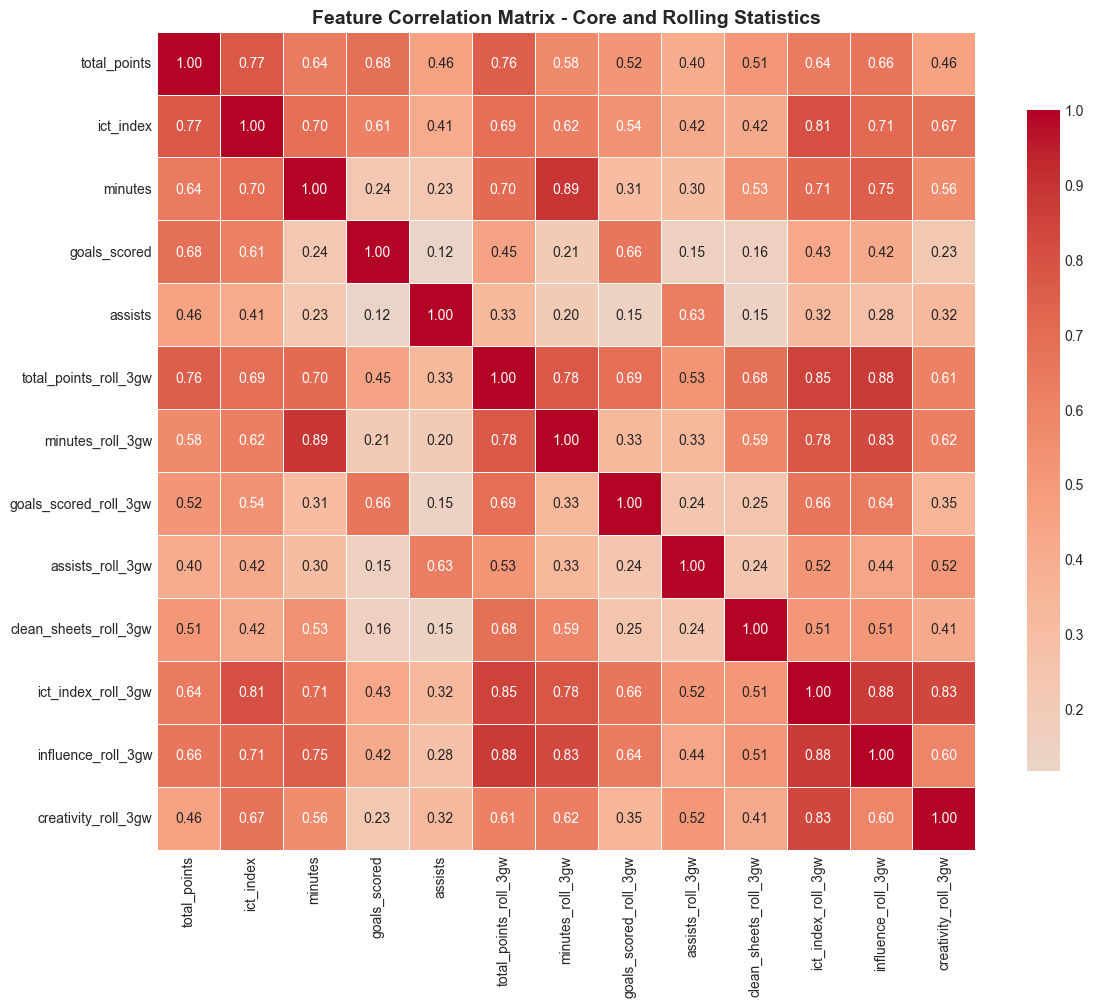


Correlation insights:
- Strong correlation between total_points and its rolling averages (expected)
- ICT components show moderate correlation (capture different aspects)
- Rolling windows of same metric highly correlated (expected temporal smoothing)




In [16]:
# Select rolling features for correlation analysis
rolling_features = [c for c in df.columns if '_roll_' in c and '3gw' in c]
core_features = ['total_points', 'ict_index', 'minutes', 'goals_scored', 'assists']

analysis_cols = core_features + rolling_features[:8]  # Limit for readability
analysis_cols = [c for c in analysis_cols if c in df.columns]

# Calculate correlation matrix on non-null subset
corr_df = df[analysis_cols].corr()

# Visualize
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix - Core and Rolling Statistics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(BASE_DIR / 'notebooks' / 'figures' / 'feature_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nCorrelation insights:")
print("- Strong correlation between total_points and its rolling averages (expected)")
print("- ICT components show moderate correlation (capture different aspects)")
print("- Rolling windows of same metric highly correlated (expected temporal smoothing)")

print("\n" + "="*80 + "\n")

## SECTION 9: TARGET VARIABLE ENGINEERING

Our prediction target is cumulative points over next 3-4 gameweeks.
We construct this forward-looking target by summing future performance.

Mathematical formulation:
    Y(i,t) = Σ(k=1 to h) total_points(i, t+k)

where h ∈ {3,4} is the forecast horizon.

CRITICAL: This target cannot be used for training at gameweek t. It represents
future information. We construct it here for validation purposes.

In [17]:
def create_forward_target(df: pd.DataFrame, horizon: int = 3) -> pd.DataFrame:
    """
    Creates forward-looking cumulative points target.
    
    This target represents the sum of points over the next `horizon` gameweeks.
    It can only be used for validation on past data or for current prediction
    where we are forecasting the unknown future.
    
    Parameters
    ----------
    df : pd.DataFrame
        Match data sorted temporally
    horizon : int
        Number of future gameweeks to sum
        
    Returns
    -------
    pd.DataFrame
        Dataframe with forward target column
    """
    df_target = df.copy()
    
    # Calculate cumulative future points per player
    df_target[f'target_points_{horizon}gw'] = (
        df_target.groupby('element')['total_points']
        .rolling(window=horizon, min_periods=1)
        .sum()
        .shift(-horizon + 1)  # Shift to align with current gameweek
        .reset_index(level=0, drop=True)
    )
    
    return df_target

# Create targets for different horizons
print("Creating forward-looking targets for horizons: 3, 4 gameweeks...")

df = create_forward_target(df, horizon=3)
df = create_forward_target(df, horizon=4)

# Validate target construction
sample_player = df[df['element'] == active_players[0]].head(10)
print("\nSample Target Construction (first 10 gameweeks of sample player):")
print(sample_player[['GW', 'total_points', 'target_points_3gw', 'target_points_4gw']])

print("\nTarget variable statistics:")
for h in [3, 4]:
    target_col = f'target_points_{h}gw'
    print(f"\n{target_col}:")
    print(df[target_col].describe())

print("\n" + "="*80 + "\n")

Creating forward-looking targets for horizons: 3, 4 gameweeks...

Sample Target Construction (first 10 gameweeks of sample player):
      GW  total_points  target_points_3gw  target_points_4gw
0      1             1                4.0                4.0
554    2             2                3.0                3.0
1120   3             1                1.0                1.0
1697   4             0                0.0                0.0
2296   5             0                0.0                0.0
2902   6             0                0.0                0.0
3513   7             0                0.0                0.0
4126   8             0                0.0                0.0
4743   9             0                0.0                0.0
5361  10             0                0.0                0.0

Target variable statistics:

target_points_3gw:
count    106943.000000
mean          3.482584
std           5.367777
min          -5.000000
25%           0.000000
50%           1.000000
75%       

## SECTION 10: SUMMARY AND NEXT STEPS

In [18]:
print("\nFeatures Constructed:")
print(f"1. Rolling performance metrics: {len([c for c in df.columns if '_roll_' in c])} features")
print("2. Position-specific analysis completed")
print("3. Target variables: target_points_3gw, target_points_4gw")

print("\nFeatures Requiring Production Implementation:")
print("1. Opponent strength adjustment (needs team ID mapping)")
print("2. Fixture density metrics (needs fixture schedule API)")
print("3. Price-performance interaction features")
print("4. Lag features (previous GW performance)")

print("\nCurrent Dataset Dimensions:")
print(f"Rows: {len(df):,}")
print(f"Columns: {len(df.columns)}")

print("\nData Quality Check:")
rolling_cols = [c for c in df.columns if '_roll_' in c]
for col in rolling_cols[:3]:
    n_missing = df[col].isna().sum()
    print(f"{col:40s}: {n_missing:6d} missing ({n_missing/len(df)*100:5.2f}%)")

print("\n" + "="*80)
print("FEATURE ENGINEERING EXPLORATION COMPLETE")
print("="*80)


Features Constructed:
1. Rolling performance metrics: 26 features
2. Position-specific analysis completed
3. Target variables: target_points_3gw, target_points_4gw

Features Requiring Production Implementation:
1. Opponent strength adjustment (needs team ID mapping)
2. Fixture density metrics (needs fixture schedule API)
3. Price-performance interaction features
4. Lag features (previous GW performance)

Current Dataset Dimensions:
Rows: 106,945
Columns: 80

Data Quality Check:
total_points_roll_3gw                   :      0 missing ( 0.00%)
total_points_roll_5gw                   :      0 missing ( 0.00%)
minutes_roll_3gw                        :      0 missing ( 0.00%)

FEATURE ENGINEERING EXPLORATION COMPLETE


In [19]:
# Save engineered features for next phase
output_path = PROCESSED_DIR / "fpl_features_exploratory.csv"
df.to_csv(output_path, index=False)
print(f"\nEngineered features saved to: {output_path}")


Engineered features saved to: c:\Users\kadmi\Workspace\02_Projects\fpl-advisor-engine\data\processed\fpl_features_exploratory.csv
